In [ ]:
!pip install split-folders -q

In [ ]:
import os
import time
import copy
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
base_dir = "/content/dogs_and_cats_unzipped"

input_folder = os.path.join(base_dir, "train")
output_folder = os.path.join(base_dir, "split")

# train / val bo‘lib ajratamiz (80/20)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))


Copying files: 557 files [00:00, 6329.82 files/s]


In [ ]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(base_dir, "split")
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ GPU is working: {torch.cuda.is_available()}")
print(f"Animal: {class_names}")


✅ GPU is working: True
Animal: ['cats', 'dogs']


In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} | Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\n✅ Trening finished. {time_elapsed//60:.0f} minute, accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)



Epoch 1/5
--------------------
train | Loss: 0.5856  Acc: 0.6787
val | Loss: 0.3772  Acc: 0.8929

Epoch 2/5
--------------------
train | Loss: 0.3506  Acc: 0.8607
val | Loss: 0.2699  Acc: 0.9107

Epoch 3/5
--------------------
train | Loss: 0.2633  Acc: 0.9079
val | Loss: 0.2499  Acc: 0.9286

Epoch 4/5
--------------------
train | Loss: 0.2214  Acc: 0.9236
val | Loss: 0.2022  Acc: 0.9286

Epoch 5/5
--------------------
train | Loss: 0.2012  Acc: 0.9258
val | Loss: 0.1871  Acc: 0.9643

✅ Trening finished. 0 minute, accuracy: 0.9643


In [ ]:
torch.save(model.state_dict(), "/content/dogs_and_cats_unzipped_resnet18.pth")
print("✅ Model saved!")

✅ Model saved!


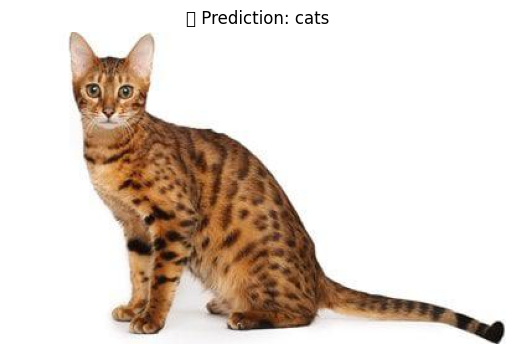

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    transform = data_transforms["val"]
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)
        pred_label = class_names[preds[0]]

    plt.imshow(np.asarray(img))
    plt.title(f"🔮 Prediction: {pred_label}")
    plt.axis("off")
    plt.show()

# Example usage with an image from the training data
# Replace this with the path to your desired test image
example_image_path = "/content/dogs_and_cats_unzipped/train/cats/cat_137.jpg" # Using an existing image for demonstration

if os.path.exists(example_image_path):
    predict_image(example_image_path)
else:
    print(f"Error: The image file '{example_image_path}' was not found.")